# Melbourne House Pricing
## By Aschwin Schilperoort

link: https://www.kaggle.com/anthonypino/melbourne-housing-market/data

In this notebook we're going to analyze the Melbourne house dataset to see if we can make some predictions on what houses are a good investment.

## Importing the libraries

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, skew
from scipy import stats

## Loading the dataset

In [2]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

# Making a column name list
columns = list(df.columns.values)
print("all_data size is : {}".format(df.shape))
df.head()

all_data size is : (29217, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


At first glance it looks like we have a dataset with 29217 houses and 21 features. We have a Price column which can be seen as a response variable. The Price columns contains a lot of missing values, the entire dataset does, to be honest... The NaN values in Price can be predicted by making a good model on the values we do know, which can later be used to search out good investments.

We should buy houses which are below our predicted value!

In [3]:
df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode           int64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

Shows us the data types of all the features in our dataset. Some of them are wrong, namely. Date is not an object but a date time, datatype. Postcode is not an integer but a category, and likewise bedrooom, bathroom and car are not floats, but categories. We'll have to fix these later on!

In [4]:
#df["Date"] = pd.to_datetime(df["Date"],dayfirst=True)

## Our response variable Price

1056543.217417943
11200000.0


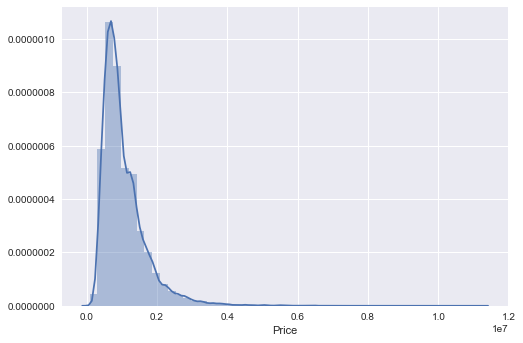

In [5]:
# Saving our response vector Price.
Price = df['Price']
print(np.mean(Price))
print(np.max(Price))

# Let's see what Price looks like!
sns.distplot(df['Price'].dropna())
plt.show()

So we can see our Price is skewed to the right (positively), and most Price values are around 0.1*10^7, so 1 milion dollars. Now we want to normalize this data so we'll use a log transformation to make it 'more' normal.


 mu = 13.73 and sigma = 0.52



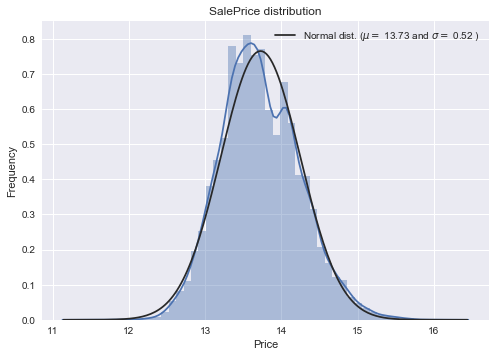

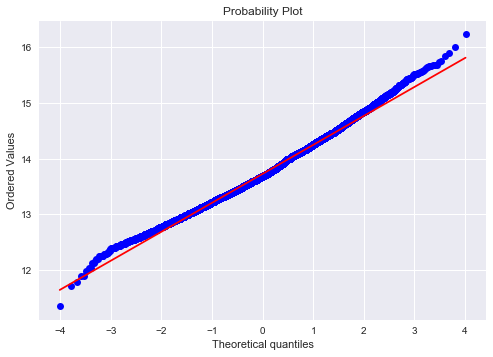

In [6]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["Price"] = np.log1p(df["Price"])

#Check the new distribution 
sns.distplot(df["Price"].dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df["Price"].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df["Price"].dropna(), plot=plt)
plt.show()

Looks normal enough. So now we're able to make better predictions for the house prices! Models like normally distributed variables.

## Relationship with numerical variables
Let's see what Price likes, what variables are correlated with Price!?

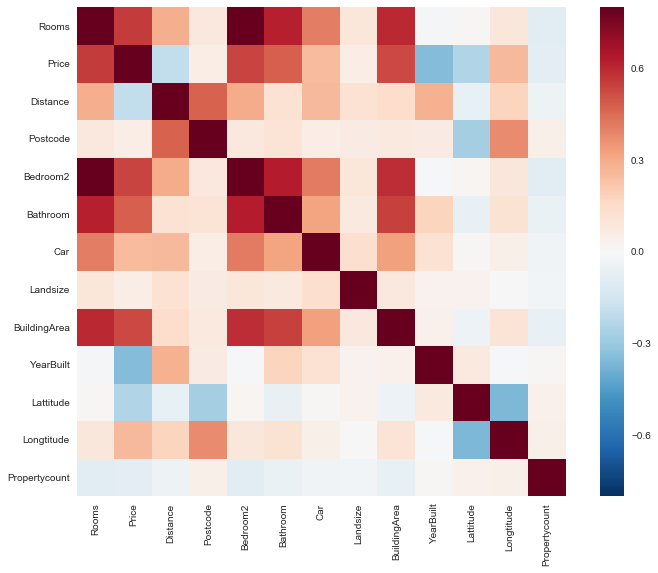

In [7]:
# Correlation Matrix
corrmat = df.dropna().corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True)
plt.show()

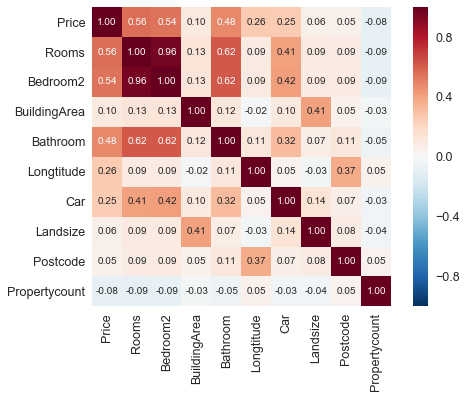

In [8]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df[cols].dropna().values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

I don't know what happened to BuildingArea, but its value is supposed to be 0.52. So we can conclude that Rooms, Bedroom2, BuildingArea, Bathroom, Longtitude and Car are the most influential numerical features for Price! Let's drop everything else and make a model. We can also drop Bedroom2, since it has a 0.96 correlation coefficient with Rooms. 

And what is going on with Landsize? Appearantly Landsize doesn't really matter in Australia, who figured? We have to explore Landsize a bit further.

## Linearity?

Let's take a look at how all the different numerical features are distributed. Also we're able to find some obvious outliers this way!

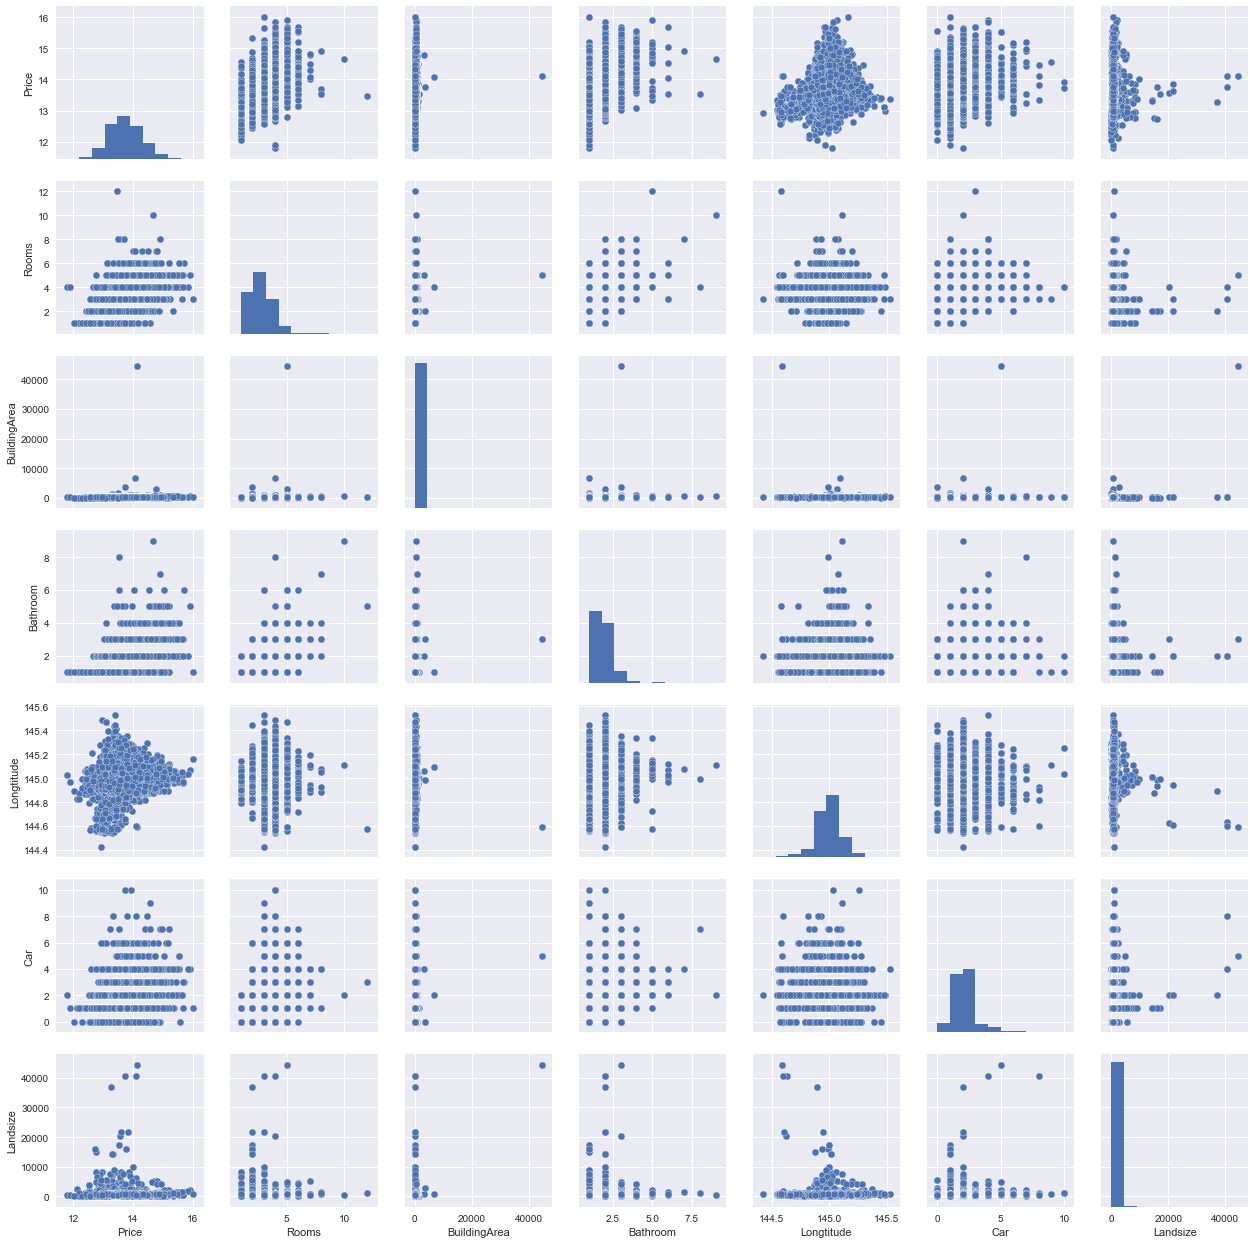

In [9]:
#scatterplot
sns.set()
cols = ['Price', 'Rooms', 'BuildingArea', 'Bathroom', 'Longtitude', 'Car', 'Landsize'] 
#let cols be the new numerical feature vector

sns.pairplot(df[cols].dropna(), size = 2.5)
plt.show()

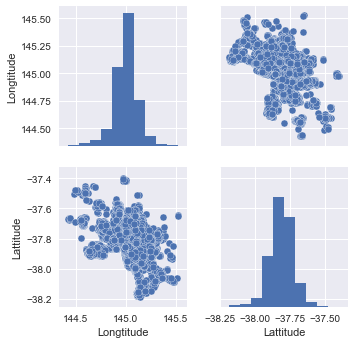

In [10]:
# The map of our area! Let see if we can plot our prices on them later on!
sns.pairplot(df[['Longtitude','Lattitude']].dropna(), size = 2.5)
plt.show()

### What's going on with Landsize?
Now we would expect land costs money, but our correlation matrix doesnt show that, and our plot doesn't show that either. Maybe if remove the highest 100 landsizes we can see what's going on.

In [11]:
df_landsize = df.drop(df[(df['Landsize']>10000)].index)

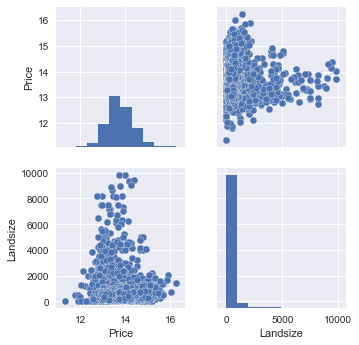

In [12]:
# Let's see what's going on with Landsize
sns.pairplot(df_landsize[['Price','Landsize']].dropna(), size = 2.5)
plt.show()

Ok there clearly is no clear relationship between Price and Landsize we can probably drop this variable all together.

We now know enough about the numerical features, but what about the categorical?

## Relationship with categorical features

We have the following categorical features:

Suburb            object
Address           object
Rooms              int64
Type              object
Method            object
SellerG           object
Postcode           int64
Bedroom2         float64
Bathroom         float64
Car              float64
YearBuilt        float64
CouncilArea       object
Regionname        object

Where all the floats and integers still have to be transformed to an object. These variables are: Rooms, Postcode, Bedroom2, Bathroom, Car, YearBuilt.

Suburb, Address, SellerG have way to many categories to be able to say anything usefull from the plots. We have to take these categories in to account when building the model.

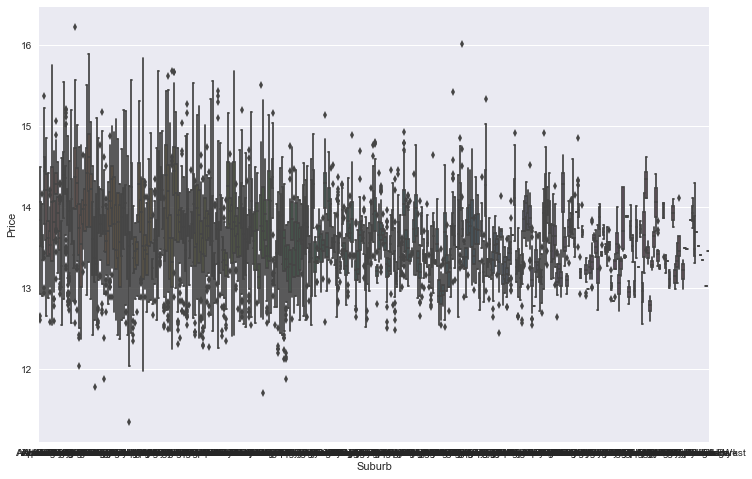

In [13]:
#box plot Suburb/saleprice
var = 'Suburb'
data = pd.concat([df['Price'].dropna(), df[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

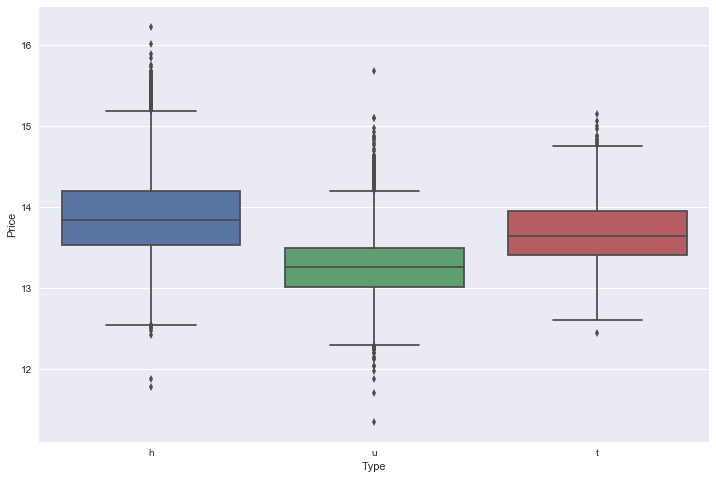

In [14]:
#box plot Type/saleprice
var = 'Type'
data = pd.concat([df['Price'].dropna(), df[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

So it appears that h - house, has the highest price compared to u - unit, duplex and t - townhouse. It also appears we don't have any of the other categories like br - bedroom, dev site - development sire, etc.

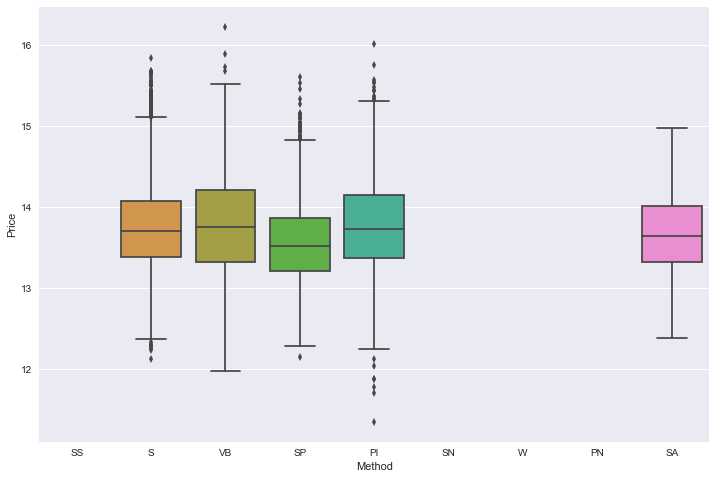

In [15]:
#box plot Method/saleprice
var = 'Method'
data = pd.concat([df['Price'].dropna(), df[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

Price doesnt really seem to care on which Method is used. So we can consider dropping this variable all together. 

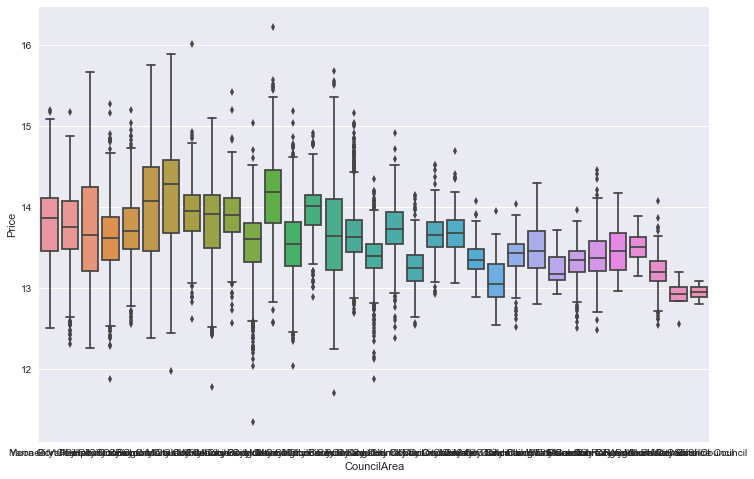

In [16]:
#box plot SellerG/saleprice
var = 'CouncilArea'
data = pd.concat([df['Price'].dropna(), df[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

CounsilArea does seem to matter. So we definitely have to take this with use in our model.

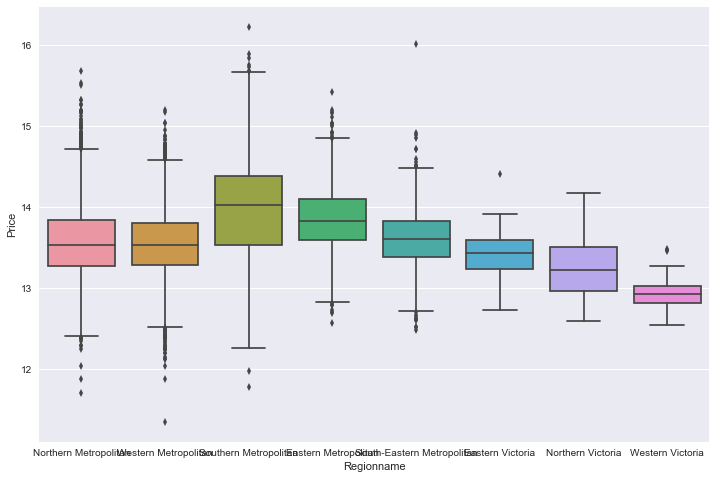

In [17]:
#box plot Regionname/saleprice
var = 'Regionname'
data = pd.concat([df['Price'].dropna(), df[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

Price really seems to be dependant on what Region the house is in. Southern Metropolian seems to be the most expensive Region, while Western Victoria seems to be the cheapest. Now we don't know where these regions lay (exactly), but we have to take in to account that this variable is probably very dependent on lattitude and longitude. So we can consider dropping some of the variables.

## Outliers
The scatterplots show some outliers, Buildingarea over 400.000? Let's find it and remove it, and some more maybe?

In [18]:
df = df.drop(df[(df['BuildingArea']>2000) | (df['Landsize']>30000)].index)

In [19]:
print(df[(df['BuildingArea']>2000) | (df['Landsize']>30000)].index)
print("all_data size is : {}".format(df.shape))

Int64Index([], dtype='int64')
all_data size is : (29197, 21)


So the outliers are gone. Now if you want to go back, run the scatterplots again so you can really see that they're gone. We lost 20 entries of data.

## Missing data

In [20]:
# Checking for missing data
df_na = (df.isnull().sum()/len(df))*100
df_na = df_na.drop(df_na[df_na==0].index).sort_values(ascending=False)[:30]
df_na.head(30)
missing_data = pd.DataFrame({'Missing Ratio': df_na})
missing_data.head(30)

,Missing Ratio
BuildingArea,59.560914
YearBuilt,53.868548
Landsize,32.767065
Car,23.495565
Bathroom,22.461212
Bedroom2,22.440662
Price,21.793335
Longtitude,21.711135
Lattitude,21.711135
Propertycount,0.006850


As we can see there is a lot of missing data in this dataset. Since we've took the first 30 and only got 12 variables it appears that only these 12 variables contain missing data.
Notice Rooms is not on here and Bedroom2 has 22% missing data. Because these variables are highly collerated we can drop Bedroom2 all together. Let's take a look at the rest!

## Taking care of missing data
We have several options:
* Drop all missing entries. -> We'll try this one first in **df1!**
* Try to predict missing values through other variables.
* Drop the entire variable all together.

### BuildingArea
Since BuildingArea is a very important predictor for our model, we have to be carefull here. Since dropping the entire variable is not wise, because it's highly correlated with Price.

In [21]:
# Dropping all rows with missing values in BuildingArea
df1 = df.copy()
df1 = df1.drop(df1.loc[df1['BuildingArea'].isnull()].index)
df1 = df1.drop(df1.loc[df1['BuildingArea']==0].index) # A BuildingArea of 0 doesn't make sense
print("df1 size is : {}".format(df1.shape))

df1 size is : (11744, 21)


### Landsize
Since Price is our response let drop Landsize next. Let's drop this variable all together because it doesn't give us any information about Price.

In [22]:
# Dropping Landsize variable
df1 = df1.drop('Landsize',1)
print("df1 size is : {}".format(df1.shape))

df1 size is : (11744, 20)


In [23]:
# Dropping all rows with missing values in Longitude, Lattitude, Price & Yearbuilt
df1 = df1.drop(df1.loc[df1['Lattitude'].isnull()].index)
df1 = df1.drop(df1.loc[df1['YearBuilt'].isnull()].index)
df1 = df1.drop(df1.loc[df1['Car'].isnull()].index)
print("df1 size is : {}".format(df1.shape))

df1 size is : (11186, 20)


In [24]:
# Checking to see if the missing data is actually gone!
df1_na = (df1.isnull().sum()/len(df1))*100
df1_na = df1_na.drop(df1_na[df1_na==0].index).sort_values(ascending=False)[:30]
df1_na.head(30)
missing_data = pd.DataFrame({'Missing Ratio': df1_na})
missing_data.head(30)

,Missing Ratio
Price,22.572859


Now we are where we want to be! We only have rows left where the only missing value in that row is Price! Let's remove these variables and make it our buying-set! Our buying set is sort-a like a test set, but we can't really compare our values. So we can't really see how good the model is doing. We call it a buying set because we can consider buying these houses when the actual price is lower then our predicted price. If this is the case we can maybe flip the houses for profit!

But first let's also drop all the variables we're not interested in!

## Dropping variables we don't need here!

In [25]:
# Dropping variables we're not interested in.
df1 = df1.drop('Bedroom2',1) # Identical to rooms
df1 = df1.drop('Method',1) # Doesnt influence price
df1 = df1.drop('Propertycount',1) # Doesnt influence price
df1 = df1.drop('Date',1) # Doesnt influence price
df1 = df1.drop('Address',1) # Doesnt influence price
df1 = df1.drop('SellerG',1) # Doesnt influence price
df1 = df1.drop('Postcode',1) # Is almost identical to Suburb
df1 = df1.drop('Lattitude',1) # Doesnt influence price

print("df1 size is : {}".format(df1.shape))

df1 size is : (11186, 12)


## Removing all NaN Price indices and adding them to a new vector

In [26]:
# Removing all rows with NaN values in Price, and saving it as a buying dataset.
print("df1 size is : {}".format(df1.shape))

df_buy = df1.loc[df1['Price'].isnull()]
df1 = df1.drop(df1.loc[df1['Price'].isnull()].index)

print("df1 size is : {}".format(df1.shape))
print("df_buy size is : {}".format(df_buy.shape))

df1 size is : (11186, 12)
df1 size is : (8661, 12)
df_buy size is : (2525, 12)


In [27]:
# Checking to see if the missing data is actually gone!
df1_na = (df1.isnull().sum()/len(df1))*100
df1_na = df1_na.drop(df1_na[df1_na==0].index).sort_values(ascending=False)[:30]
df1_na.head(30)
missing_data = pd.DataFrame({'Missing Ratio': df1_na})
missing_data.head(30)

,Missing Ratio


Awesome! We have no more missing data. Let's do some more feature engineering!

## More feature engineering

### Transforming some numerical variables that are really categorical
Variables to be transformed: Rooms, Postcode, Bedroom2, Bathroom, Car, YearBuilt


In [28]:
# Making Rooms a categorical variable
df1['Rooms'] = df1['Rooms'].apply(str)

#Changing OverallCond into a categorical variable
#df1['Postcode'] = df1['Postcode'].astype(str)

# Bathroom, Car & Yearbuilt into categorical features.
df1['Bathroom'] = df1['Bathroom'].astype(str)
df1['Car'] = df1['Car'].astype(str)
df1['YearBuilt'] = df1['YearBuilt'].astype(str)


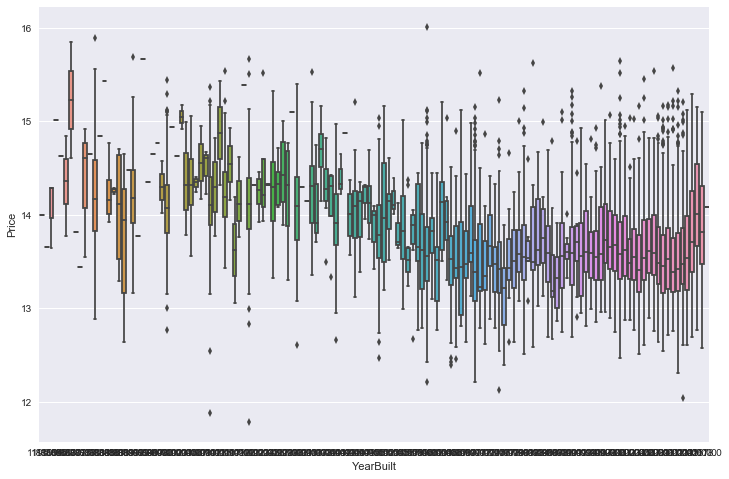

In [29]:
#box plot YearBuilt/saleprice
var = 'YearBuilt'
data = pd.concat([df1['Price'], df1[var].dropna()], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.show()

Appearantly newer houses tend to become cheaper? Now we can also plot the rest, but we already know that these variables influence Price. 

## Skewed features

In [30]:
# skewed features
from scipy.special import boxcox1p

num = df1.dtypes[df1.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df1[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
BuildingArea,2.887384
Distance,1.562574
Price,0.306090
Longtitude,-0.325103


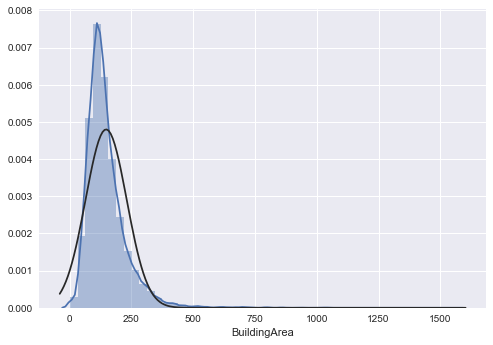

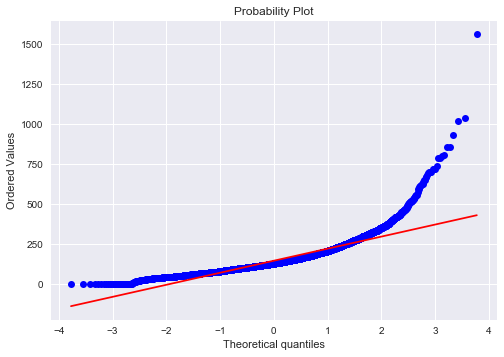

In [31]:
# Let's check what's going on with BuildingArea!
sns.distplot(df1['BuildingArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['BuildingArea'], plot=plt)
plt.show()

In [32]:
# BuildingArea is skewed and shows peakedness. Let log it!
lam = 0.2
#df1['BuildingArea'] = np.log(df1['BuildingArea'])
df1['BuildingArea'] = boxcox1p(df1['BuildingArea'], lam)

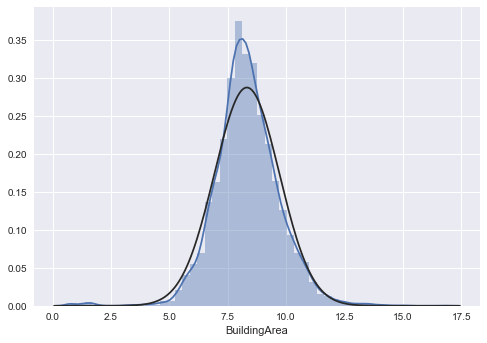

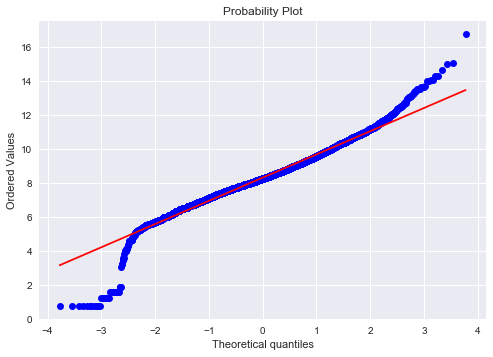

In [33]:
# transformed BuildingArea
sns.distplot(df1['BuildingArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['BuildingArea'], plot=plt)
plt.show()

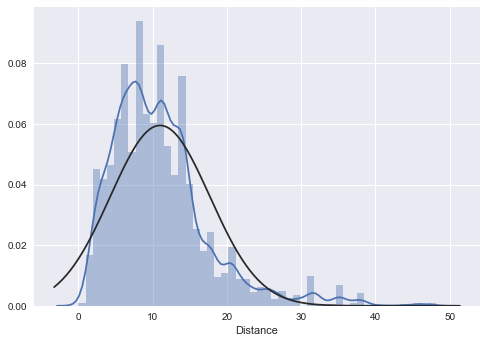

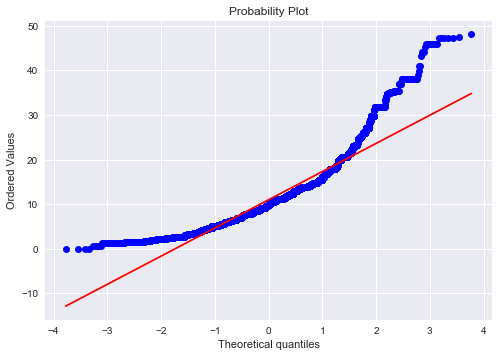

In [34]:
# Let's check what's going on with Distance!
sns.distplot(df1['Distance'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['Distance'], plot=plt)
plt.show()

In [35]:
# Distance is skewed and shows peakedness. Let log it!
lam = 0.4
#df1['Distance'] = np.log1p(df1['Distance'])
df1['Distance'] = boxcox1p(df1['Distance'], lam)

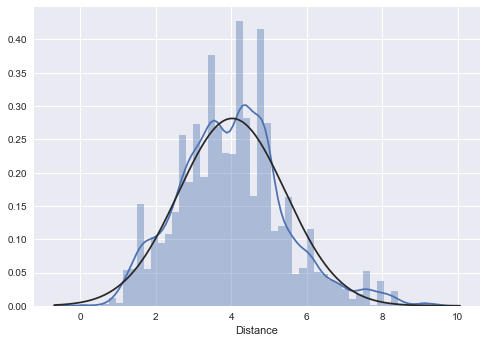

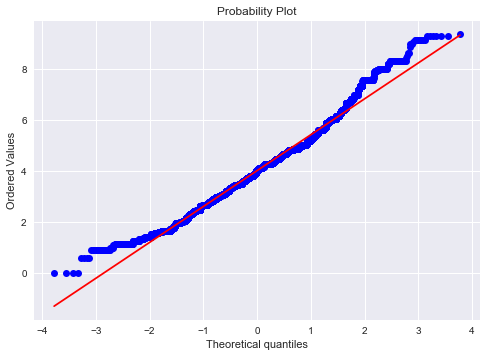

In [36]:
# transformed BuildingArea
sns.distplot(df1['Distance'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['Distance'], plot=plt)
plt.show()

In [37]:
# Checking to see if skew is below 1!
num = df1.dtypes[df1.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df1[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Distance,0.440051
Price,0.306090
BuildingArea,-0.167325
Longtitude,-0.325103


So no more skew! Great. Since all our numerical variables are somewhat normal we can start building our model! Beware that for some models we always have to scale the variables aswell!

## Getting Dummy Categorical features

For our model to interpret the categorical variables, we have to encode them with dummy variables. We'll make a new dataframe with dummy's called dfd

In [38]:
print('Shape df1: {}'.format(df1.shape))

Shape df1: (8661, 12)


In [40]:
dfd = df1.copy()
dfd = pd.get_dummies(dfd)
print(dfd.shape)

(8661, 530)


In [44]:
df1.head()

,Suburb,Rooms,Type,Price,Distance,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Longtitude,Regionname
2,Abbotsford,2,h,13.849913,1.626361,1.0,0.0,7.011244,1900.0,Yarra City Council,144.9934,Northern Metropolitan
4,Abbotsford,3,h,14.197366,1.626361,2.0,0.0,8.638462,1900.0,Yarra City Council,144.9944,Northern Metropolitan
6,Abbotsford,4,h,14.285515,1.626361,1.0,2.0,8.490785,2014.0,Yarra City Council,144.9941,Northern Metropolitan
11,Abbotsford,3,h,14.444653,1.626361,2.0,0.0,9.582316,1910.0,Yarra City Council,144.9993,Northern Metropolitan
14,Abbotsford,2,h,14.307765,1.626361,1.0,2.0,7.754245,1890.0,Yarra City Council,144.9954,Northern Metropolitan


## Time to make the models!

In [43]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# Defining the response variable
y

In [ ]:
# Splitting the data in train & test

In [ ]:


#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)